In [26]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

import sklearn as sk
import scipy as sp
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import math
import time

In [61]:
# Import and organize data. Use only FSR data

# Import and organize data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d1 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)

In [68]:
labels = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [2]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data # dataset
Y = iris.target # label

In [62]:
# FEATURES

# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

# This feature takes the max of each column, takes the data point [change_factor] ms after that, and then normalizes 
# the difference

def change_in_max(column, change_factor):
    max_index = np.argmax(column)
    minus_change_index = max_index - change_factor
    if minus_change_index > 0:
        minus_change_value = column[minus_change_index]
    else:
        minus_change_index = max_index + change_factor
        minus_change_value = column[minus_change_index]
    diff = np.max(column) - minus_change_value
    normalized = diff/np.std(column)
    return normalized

# This function takes all 72 data points of size (7001,16) and puts them into a feature-engineered array.
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent, change_in_max_change_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 6
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = change_in_max(column,change_in_max_change_factor)
            D[5,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

In [63]:
# Condense data into averages over a specified number of data points

def condense(array, condense_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
    return condensed_data

In [64]:
# Takes the max of all features from the 16 datapoints. Output is 72 sets of 1 by 6 data, where each of the 6 points
# is the max of each feature from the set. 

def everything_max(array):
    len_dataset, num_features, num_datapoints = np.shape(array)
    maxed_data = np.zeros((len_dataset, 1, num_features))
    for i in range(len_dataset):
        datapoint = array[i]
        D = np.zeros((1, num_features))
        for j in range(num_features):
            D[0,j] = max(datapoint[:,j])
        maxed_data[i] = D
    return maxed_data

In [65]:
# Normalize and feature-ify the data
normalized_data = data/np.max(data)
normalized_featured_data = features(normalized_data,.75,50)
np.shape(normalized_featured_data)

# Make dataset that only has max of each feature
maxed_data = everything_max(normalized_featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

In [75]:
# Turn 3D array into 2D array

def two_d(maxed_data):
    len_data, _, num_points = np.shape(maxed_data)
    data = np.zeros((len_data, num_points))
    for i in range(len(maxed_data)):
        data[i] = maxed_data[i][0]
    return data

x = two_d(maxed_data)

In [69]:
# Binarize the output
# y = label_binarize(y, classes=[0,1,2]) # gives each label an array of 3 digits. e.g. if the label is 2, array is [0,1,2]
# n_classes = y.shape[1]

In [74]:
y = labels

In [93]:
# Binarize
y = label_binarize(y, classes=[0,1,2,3])
n_classes = y.shape[1]

In [56]:
# np.shape(X[1])

(804,)

In [11]:
# Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200*n_features)]

In [13]:
# # shuffle and split training and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, random_state=0)

In [140]:
# shuffle and split training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(5/72), random_state=0)

In [141]:
# Learn to predict one class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                        random_state=random_state))
y_score = classifier.fit(x_train, y_train).decision_function(x_test)

In [142]:
y_score

array([[  1.39051113,  16.61217209, -22.44062681,  -7.19542744],
       [-36.89831605,  13.32412107,  -0.62279804, -20.68490746],
       [ -2.16851379,  19.38150573, -13.61203736, -14.72544425],
       [-29.34769553,   8.55962063,  -1.18369171, -22.06859798],
       [-27.2132914 ,   2.40230902,   6.32252924, -27.48814128]])

In [143]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [144]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

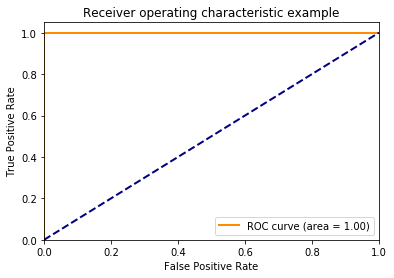

In [145]:
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color = 'darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()